<a href="https://colab.research.google.com/github/Kambey-san/PyTorch_base/blob/HW_lesson_03/HW_lesson_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Урок 3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация/ ДЗ

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.8 MB/s eta 0:00:00


In [ ]:
# загрузка датасета
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

# разделение датасета
from sklearn.model_selection import train_test_split

# преобразование данных
from sklearn.preprocessing import MinMaxScaler
from torchvision import transforms

#построение модели
import torch
import torch.nn as nn
import torch.nn.functional as F

# метрика
import torchmetrics

#отрисовка графиков
from matplotlib import pyplot as plt

### Задание
1. Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

### Загрузка данных

In [ ]:
housing = fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=True)
df = housing['frame']
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
# пропусков в данных нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
# целевая переменная
target = housing['target_names'][0]
target

'MedHouseVal'

In [ ]:
# список признаков
features_list = housing['feature_names']
features_list

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [ ]:
# собираем признаки и целевую переменную
X = df[features_list]
y = df[target]

In [ ]:
# разделяем датасет на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
print(f'Тренировочный набор: {X_train.shape}, {y_train.shape}')
print(f'Тестовый набор: {X_test.shape}, {y_test.shape}')

Тренировочный набор: (15480, 8), (15480,)
Тестовый набор: (5160, 8), (5160,)


In [ ]:
#стандартизация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train).float()
y_train = torch.FloatTensor(y_train.values).float()

X_test = torch.FloatTensor(X_test).float()
y_test = torch.FloatTensor(y_test.values).float()

### Dataset и Dataloader

In [ ]:
# класс датасета
class MyOwnClass(torch.utils.data.Dataset):

    def __init__(self, X_data, y_data):
        self._X = X_data
        self._y = y_data

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        X = self._X[idx]
        y = self._y[idx]

        return X, y

In [11]:
# создание представителя тренировочного датасета и его dataloader
train_dataset = MyOwnClass(X_train, y_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [12]:
# элементы тренировочного датасета
train_dataset[0], train_dataset[0][0].shape, train_dataset[0][1].shape

((tensor([0.2081, 0.6863, 0.0243, 0.0226, 0.0379, 0.0011, 0.1775, 0.6096]),
  tensor(2.6800)),
 torch.Size([8]),
 torch.Size([]))

In [13]:
# элементы тренировочного даталоадера
for idx, batch in enumerate(train_loader):
    print(idx, 'Tensor: ', batch[0], batch[0].shape)  # 128 батчей с 8 признаками
    print(idx, 'target: ', batch[1], batch[1].shape)  # 128 значений target
    break

0 Tensor:  tensor([[3.5903e-01, 6.2745e-01, 3.4058e-02,  ..., 1.8812e-03, 5.1222e-01,
         2.3606e-01],
        [1.3567e-01, 7.0588e-01, 1.4373e-02,  ..., 8.1968e-04, 2.2317e-02,
         7.0717e-01],
        [1.4414e-01, 8.6275e-01, 3.0833e-02,  ..., 2.2809e-03, 5.5260e-01,
         1.9422e-01],
        ...,
        [1.0122e-01, 6.2745e-01, 2.8736e-02,  ..., 2.3315e-03, 4.3146e-01,
         4.7012e-01],
        [7.9806e-02, 6.4706e-01, 2.3615e-02,  ..., 2.0325e-03, 5.7386e-01,
         1.9920e-01],
        [1.8739e-01, 2.9412e-01, 2.6578e-02,  ..., 1.7307e-03, 7.3326e-01,
         5.5777e-02]]) torch.Size([128, 8])
0 target:  tensor([2.8720, 2.1670, 2.1180, 2.6760, 1.4110, 2.5990, 0.9480, 1.5250, 1.4310,
        1.4810, 1.4070, 1.4200, 1.3400, 5.0000, 2.6700, 0.8450, 5.0000, 1.3730,
        0.9550, 2.0240, 0.6750, 4.8330, 3.5560, 1.0780, 1.9450, 1.6680, 2.7640,
        2.4180, 2.0920, 1.6260, 3.7500, 2.0720, 1.4400, 1.5970, 2.5380, 1.8690,
        2.9440, 2.2280, 2.1880, 3.8330, 0

In [14]:
# создание представителя тестового датасета и его dataloader
test_dataset = MyOwnClass(X_test, y_test)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False,
                                          drop_last=True,
                                          num_workers=0)

### Построение нейронной сети

In [15]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        raise RuntimeError

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2*hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2*hidden_dim)
        self.fc2 = Perceptron(2*hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)

    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [16]:
# инициализация модели
net = FeedForward(8, 400)

# компиляция модели
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [17]:
num_epochs = 10

train_r2 = torchmetrics.R2Score()
test_r2 = torchmetrics.R2Score()

net.train()

for epoch in range(num_epochs):

    running_loss, running_items = 0.0, 0.0

    for i, data in enumerate(train_loader):
        inputs, target = data[0], data[1]

        optimizer.zero_grad()
        outputs = net(inputs)
        train_r2(outputs.squeeze(), target)
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(target)

        # выводим статистику о процессе обучения
        if i % 60 == 0:    # печатаем каждые 60 mini-batches
            net.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}, ', \
                  f'r2_train: {train_r2.compute().item():.3f}, ', end = ' ')
            running_loss, running_items = 0.0, 0.0
            train_r2.reset()

            for i, data in enumerate(test_loader):
                test_outputs = net(data[0])
                test_r2(test_outputs.squeeze(), data[1])

            print(f'r2_val: {test_r2.compute():.3f}')
            test_r2.reset()
            net.train()

print('Training is finished!')

Epoch [1/10]. Step [1/120]. Loss: 4.486,  r2_train: -2.905,  r2_val: -2.749
Epoch [1/10]. Step [61/120]. Loss: 1.265,  r2_train: 0.044,  r2_val: 0.413
Epoch [2/10]. Step [1/120]. Loss: 0.849,  r2_train: 0.365,  r2_val: 0.509
Epoch [2/10]. Step [61/120]. Loss: 0.670,  r2_train: 0.491,  r2_val: 0.585
Epoch [3/10]. Step [1/120]. Loss: 0.492,  r2_train: 0.541,  r2_val: 0.633
Epoch [3/10]. Step [61/120]. Loss: 0.565,  r2_train: 0.573,  r2_val: 0.657
Epoch [4/10]. Step [1/120]. Loss: 0.453,  r2_train: 0.626,  r2_val: 0.666
Epoch [4/10]. Step [61/120]. Loss: 0.473,  r2_train: 0.642,  r2_val: 0.628
Epoch [5/10]. Step [1/120]. Loss: 0.489,  r2_train: 0.632,  r2_val: 0.660
Epoch [5/10]. Step [61/120]. Loss: 0.453,  r2_train: 0.660,  r2_val: 0.708
Epoch [6/10]. Step [1/120]. Loss: 0.424,  r2_train: 0.659,  r2_val: 0.650
Epoch [6/10]. Step [61/120]. Loss: 0.433,  r2_train: 0.670,  r2_val: 0.710
Epoch [7/10]. Step [1/120]. Loss: 0.364,  r2_train: 0.676,  r2_val: 0.719
Epoch [7/10]. Step [61/120]. L

### Модели нейронной сети с разными оптимизаторами

In [18]:
def train_eval_model(model, optimizer, num_epochs):

    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()

    r2_train_list = []
    r2_test_list = []

    for epoch in range(num_epochs):

        model.train()
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1] # входные данные с лейблами
            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = model(inputs)
            #метрика
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs.squeeze(), target)
            # Вычисляем градиент
            loss.backward()
            # Обновляем веса (делаем шаг оптимайзера)
            optimizer.step()

        model.eval()
        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()

        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_val = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()

    return r2_train_list, r2_test_list

In [19]:
# функция визуализации метрик
def visual_metrics(r2_train_list, r2_test_list, optim):
    x = np.arange(1,11,1)
    y = r2_train_list
    y2 = r2_test_list

    plt.plot(x,y,label='R2_train')
    plt.plot(x,y2,label='R2_test')

    plt.title(f"NN with optim {optim}")
    plt.ylabel('R2_score')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

In [20]:
torch.manual_seed(10)

#### Оптимизатор SGD

In [21]:
model = FeedForward(8, 400)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum =0.0)
r2_train_list_SGD, r2_test_list_SGD = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = 0.017322838306427002, r2_val = 0.4502796530723572
Epoch 2: r2_train = 0.3981422781944275, r2_val = 0.4996601343154907
Epoch 3: r2_train = 0.48378825187683105, r2_val = 0.5801624655723572
Epoch 4: r2_train = 0.5234606266021729, r2_val = 0.591178297996521
Epoch 5: r2_train = 0.5569790005683899, r2_val = 0.5861023664474487
Epoch 6: r2_train = 0.5796942710876465, r2_val = 0.5690022706985474
Epoch 7: r2_train = 0.6183960437774658, r2_val = 0.6320518255233765
Epoch 8: r2_train = 0.6470893621444702, r2_val = 0.6853398084640503
Epoch 9: r2_train = 0.6541188359260559, r2_val = 0.6411216259002686
Epoch 10: r2_train = 0.6763498783111572, r2_val = 0.672605037689209


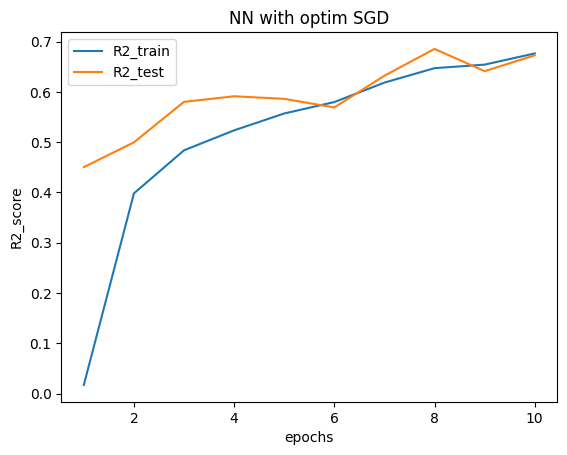

In [22]:
visual_metrics(r2_train_list_SGD, r2_test_list_SGD, 'SGD')

#### Оптимизатор Adam¶

In [23]:
model = FeedForward(8, 400)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
r2_train_list_Adam, r2_test_list_Adam = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = 0.15409058332443237, r2_val = 0.5270931720733643
Epoch 2: r2_train = 0.5050986409187317, r2_val = 0.5877457857131958
Epoch 3: r2_train = 0.5735474228858948, r2_val = 0.6477715373039246
Epoch 4: r2_train = 0.6305599212646484, r2_val = 0.6806619763374329
Epoch 5: r2_train = 0.6615914106369019, r2_val = 0.6877420544624329
Epoch 6: r2_train = 0.6728895902633667, r2_val = 0.6998721957206726
Epoch 7: r2_train = 0.680575966835022, r2_val = 0.6644915342330933
Epoch 8: r2_train = 0.6977256536483765, r2_val = 0.6782885789871216
Epoch 9: r2_train = 0.7032991051673889, r2_val = 0.7156312465667725
Epoch 10: r2_train = 0.7048736810684204, r2_val = 0.7134469151496887


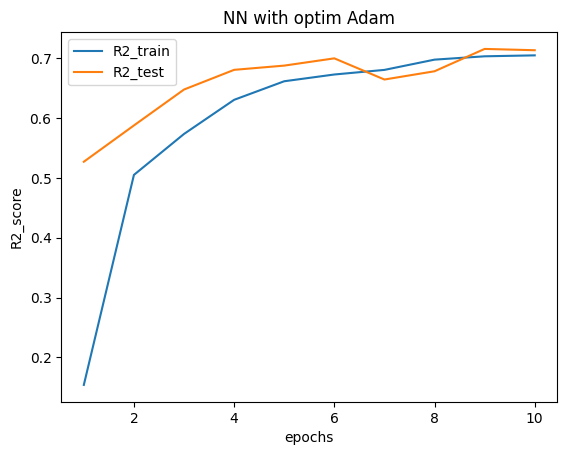

In [24]:
visual_metrics(r2_train_list_Adam, r2_test_list_Adam, 'Adam')

#### Оптимизатор RMSprop

In [25]:
model = FeedForward(8, 400)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
r2_train_list_RMS, r2_test_list_RMS = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = 0.1524564027786255, r2_val = 0.5567173957824707
Epoch 2: r2_train = 0.5357444286346436, r2_val = 0.6443504691123962
Epoch 3: r2_train = 0.5972220301628113, r2_val = 0.6325389742851257
Epoch 4: r2_train = 0.6334823369979858, r2_val = 0.654706597328186
Epoch 5: r2_train = 0.6592715382575989, r2_val = 0.7008247375488281
Epoch 6: r2_train = 0.6675530672073364, r2_val = 0.6969236135482788
Epoch 7: r2_train = 0.6800909042358398, r2_val = 0.7270369529724121
Epoch 8: r2_train = 0.6922587752342224, r2_val = 0.7145575284957886
Epoch 9: r2_train = 0.6983839273452759, r2_val = 0.7108832001686096
Epoch 10: r2_train = 0.6961566209793091, r2_val = 0.6857624053955078


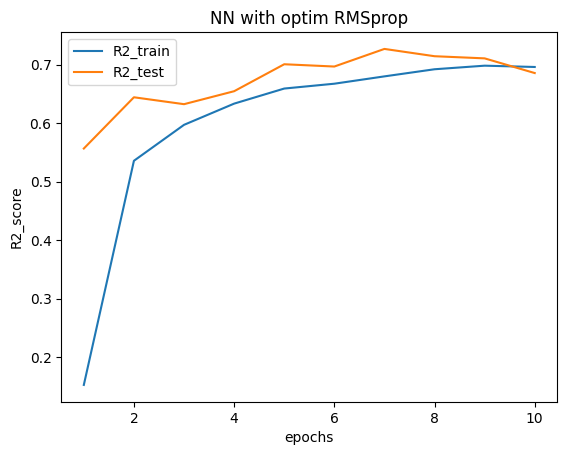

In [26]:
visual_metrics(r2_train_list_RMS, r2_test_list_RMS, 'RMSprop')

### Обобщение результатов

In [27]:
# сводная таблица метрик моделей
metrics_result = pd.DataFrame([{'r2_train': r2_train_list_SGD[-1].item(), 'r2_test': r2_test_list_SGD[-1].item()},
                               {'r2_train': r2_train_list_Adam[-1].item(), 'r2_test': r2_test_list_Adam[-1].item()},
                               {'r2_train': r2_train_list_RMS[-1].item(), 'r2_test': r2_test_list_RMS[-1].item()}],
                              index =['SGD', 'Adam', 'RMSprop'],
                              columns =['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
Adam,0.704874,0.713447
RMSprop,0.696157,0.685762
SGD,0.676350,0.672605


**Вывод:** лучшие показатели модели по метрике достигается с применением оптимизатора RMSprop.